In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pyarrow import parquet
import seaborn as sns

In [2]:
ss_df = pd.read_parquet("../refined-data/refined-SSDB.parquet")
rand_df = pd.read_parquet("../refined-data/refined-RAND.parquet")

choropleth = px.choropleth(
    rand_df,
    title="Firearm Ownership Rate v. School Shooting Incidents",
    locations="State", 
    locationmode="USA-states", 
    scope="usa",
    color="HFR",
    color_continuous_scale="Viridis",
    range_color=(rand_df["HFR"].min(), rand_df["HFR"].max()),
    animation_frame="Year",
)

ss_df_restrict = ss_df[ss_df["Date"].dt.year.between(2000, 2016)][::-1]
scatter = px.scatter_geo(
    ss_df_restrict,
    lat = ss_df_restrict["LAT"],
    lon = ss_df_restrict["LNG"],
    color_discrete_sequence=["red"],
    size=ss_df_restrict["Number_Victims"] + .1,
    labels={"size": "Number_Victims"},
    hover_data={"Number_Victims": ':.0f'},
    size_max=20 * 2.5,
    animation_frame=ss_df_restrict["Date"].dt.year,
)

fig = go.Figure(
    data=choropleth.data + scatter.data,
    frames=[
        go.Frame(data=fr1.data + fr2.data, name=fr1.name) for fr1, fr2
        in zip(choropleth.frames, scatter.frames)
    ],
    layout=choropleth.layout
)
#fig
# fig.update_layout(
#     #autosize=False,
#     #width=900,
#     #height=800,
#     #margin=dict(l=10, r=10, t=50, b=0)
# )
fig.show(renderer="browser")

In [189]:
nsduh_df = pd.read_parquet("../refined-data/refined-NSDUH.parquet")
m_illness_df = nsduh_df["Serious Mental Illness"]

choropleth = px.choropleth(
    nsduh_df,
    title="Serious Mental Illness (18 or Older) v. School Shooting Incidents",
    locations="State", 
    locationmode="USA-states", 
    scope="usa",
    color=m_illness_df["18 or Older\nEstimate"],
    labels={"color": "Severe M.I Rate"},
    color_continuous_scale="Viridis",
    range_color=(m_illness_df["18 or Older\nEstimate"].min(), m_illness_df["18 or Older\nEstimate"].max()),
    animation_frame="Year",
)

ss_df_restrict = ss_df[ss_df["Date"].dt.year.between(2016, 2019)][::-1]
scatter = px.scatter_geo(
    ss_df_restrict,
    lat = ss_df_restrict["LAT"],
    lon = ss_df_restrict["LNG"],
    color_discrete_sequence=["red"],
    size=ss_df_restrict["Number_Victims"] + .1,
    labels={"size": "Number_Victims"},
    hover_data={"Number_Victims": ':.0f'},
    size_max=20 * 2.5,
    animation_frame=ss_df_restrict["Date"].dt.year,
)

fig = go.Figure(
    data=choropleth.data + scatter.data,
    frames=[
        go.Frame(data=fr1.data + fr2.data, name=fr1.name) for fr1, fr2
        in zip(choropleth.frames, scatter.frames)
    ],
    layout=choropleth.layout
)

fig.show(renderer="browser")

In [161]:
ss_df["Date"].dt.year
three_scatter = ss_df.groupby(ss_df["Date"].dt.to_period("M"))["Number_Victims"].agg(['sum','count']).to_timestamp().reset_index()
fig = px.scatter_3d(three_scatter, x="Date", y="sum", z="count",
    title="Monthly Frequency and Magnitude of School Shooting Incidents 2000-2023",
    labels={"count": "# of Incidents", "sum": "Total Casualties"}
)

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-0.2),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.update_layout(
    scene = {
        'xaxis': {'autorange': 'reversed'},
        'yaxis': {'autorange': 'reversed'}
    },
    scene_camera=camera,
    margin=dict(l=10, r=10, t=50, b=0)
)
fig.show(renderer="browser")

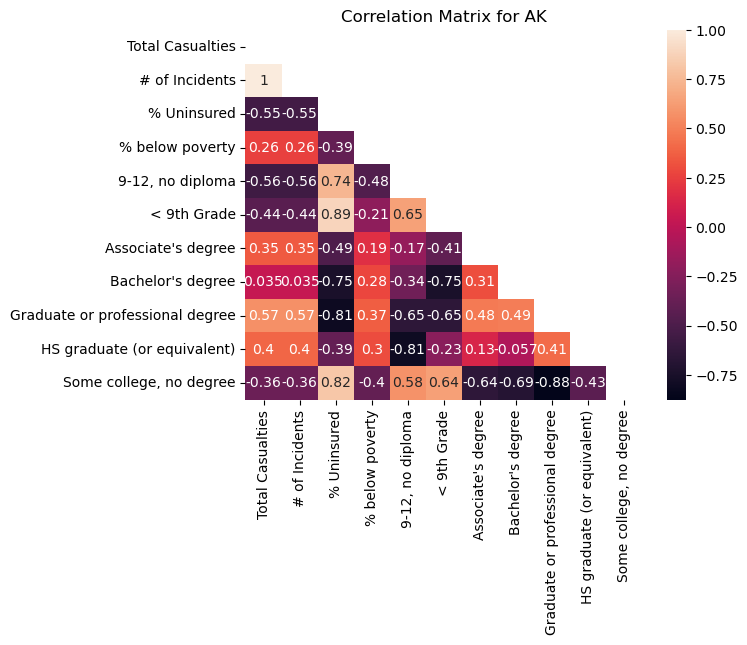

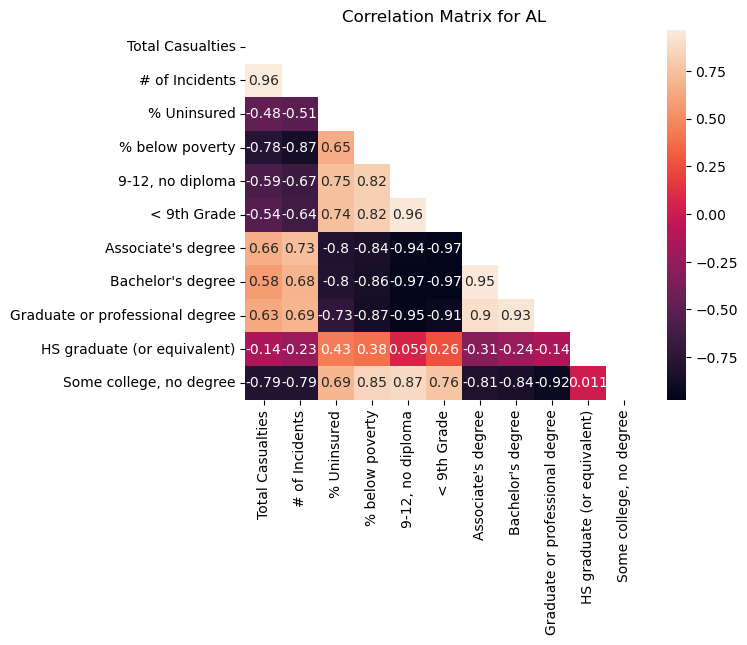

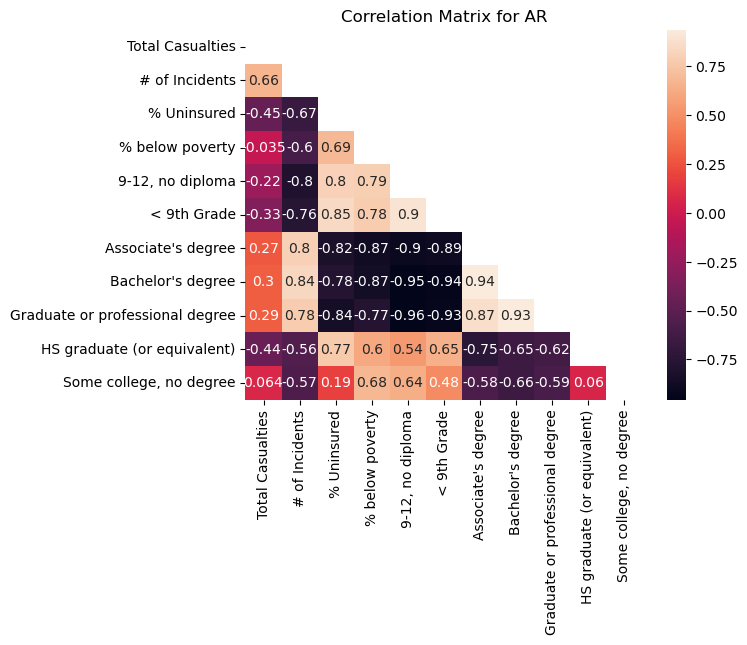

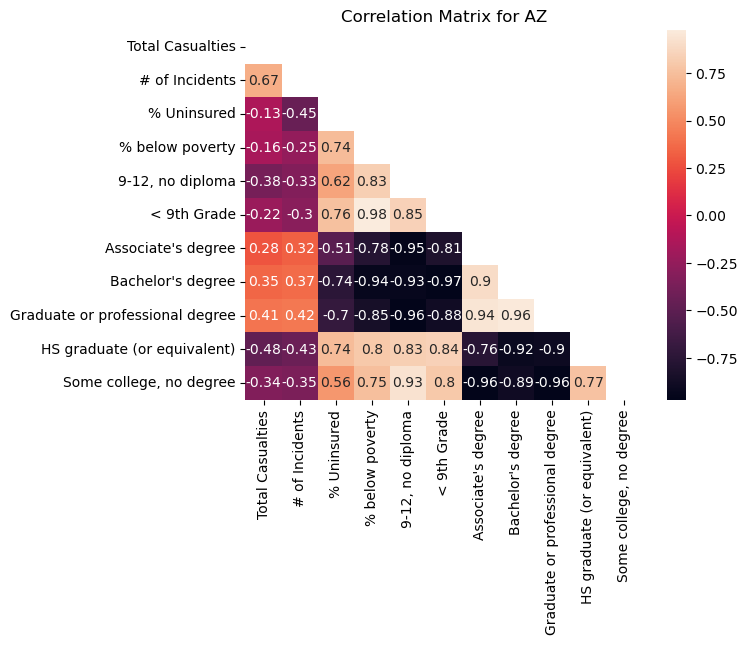

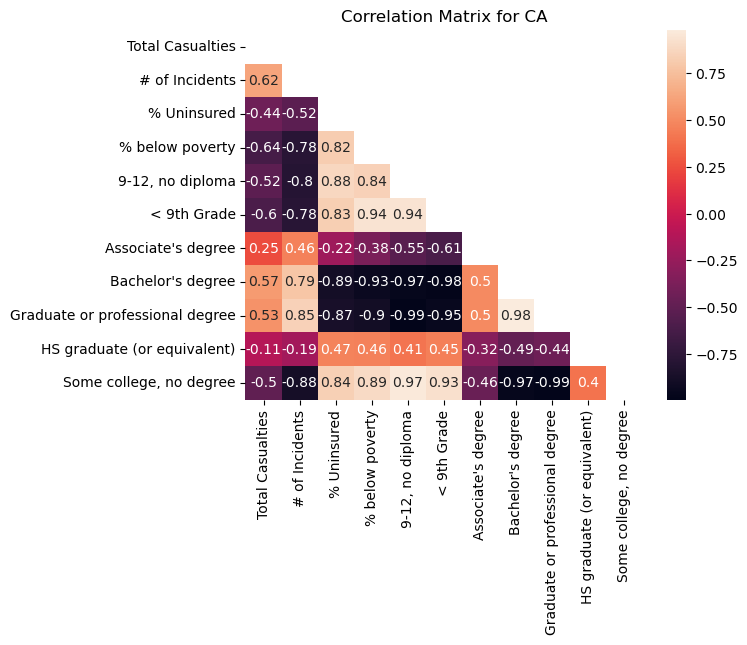

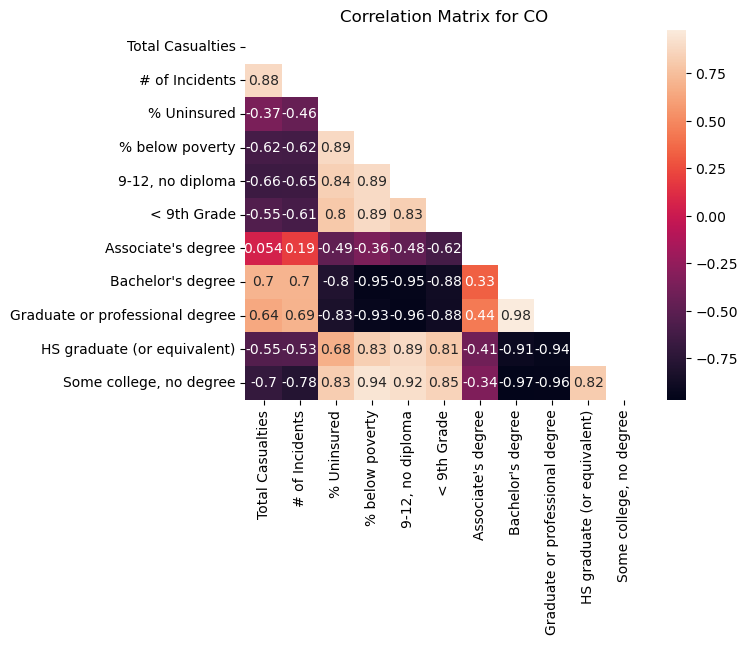

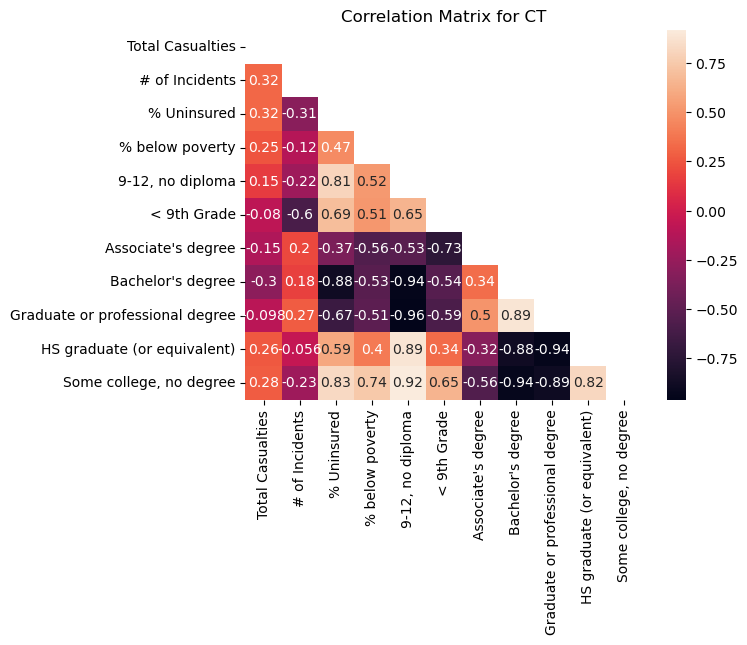

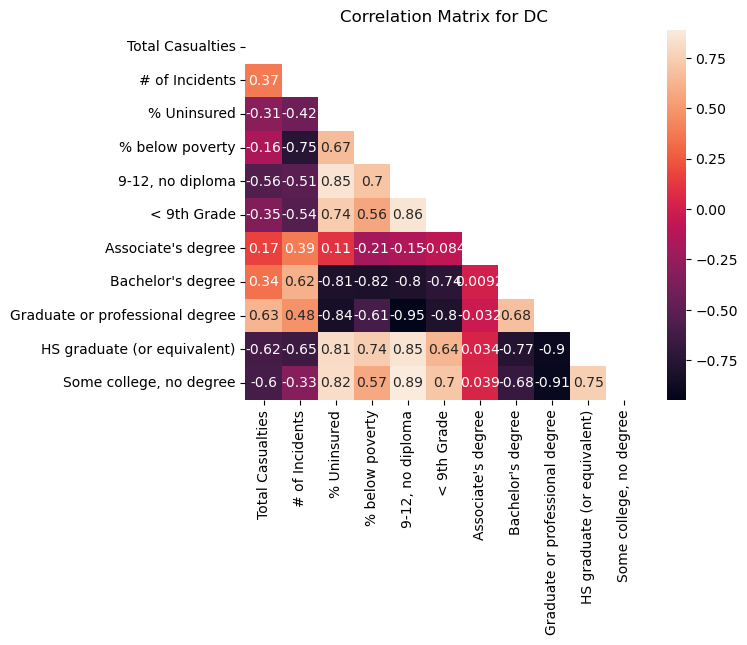

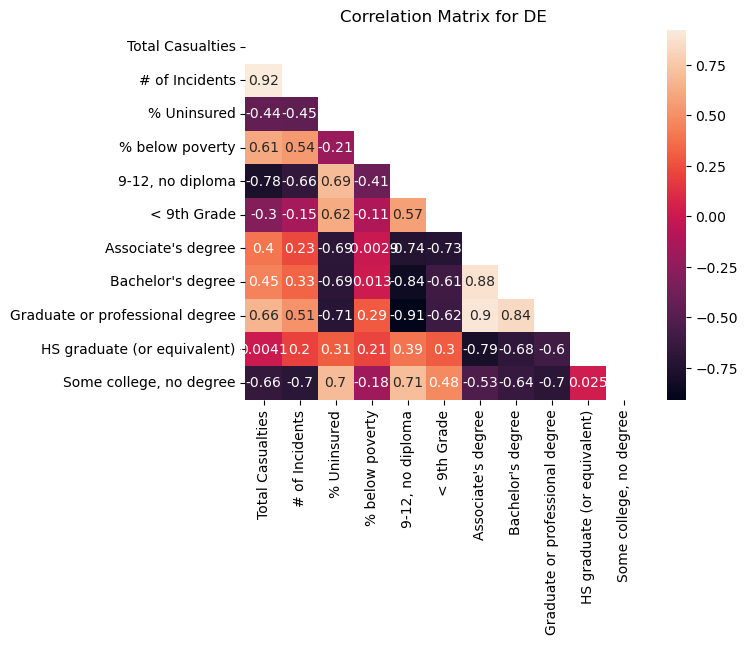

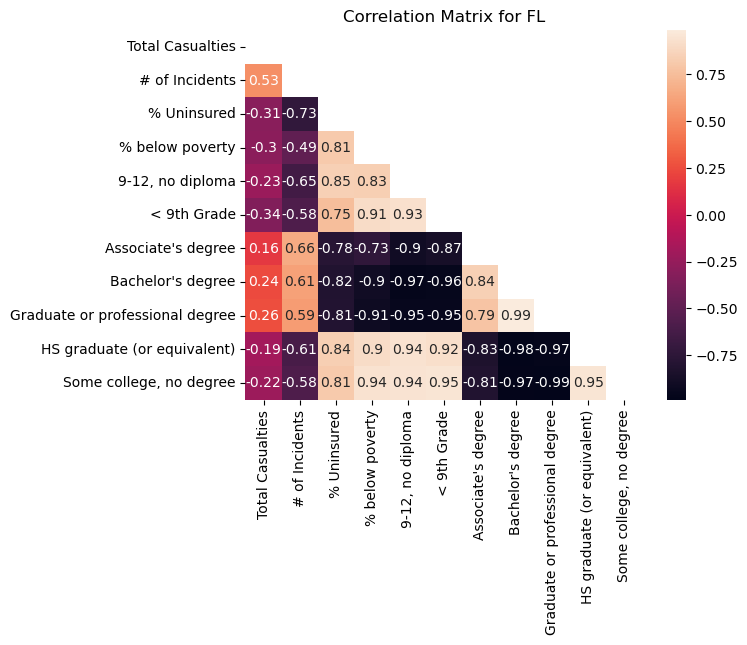

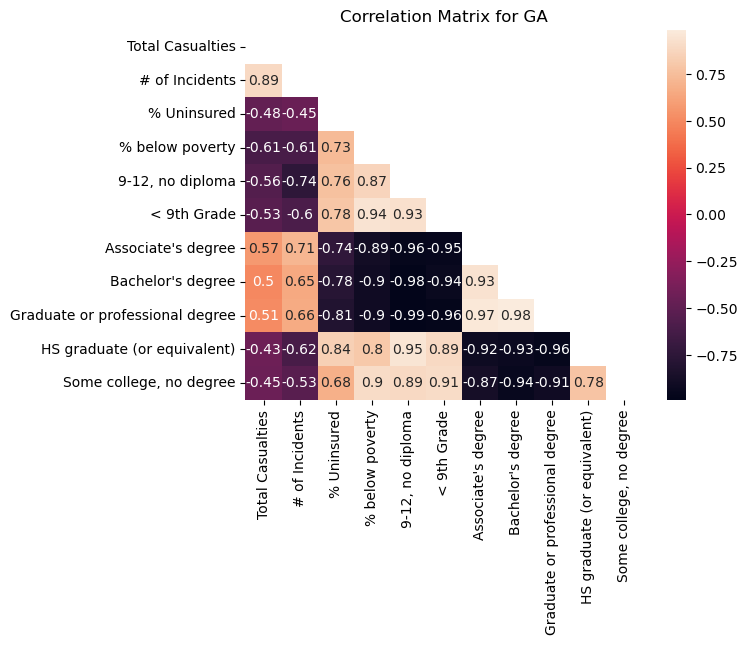

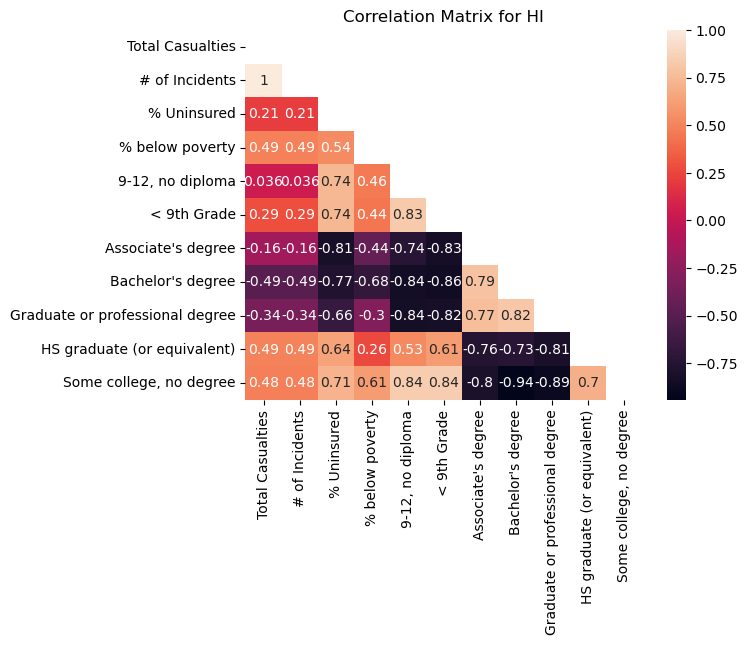

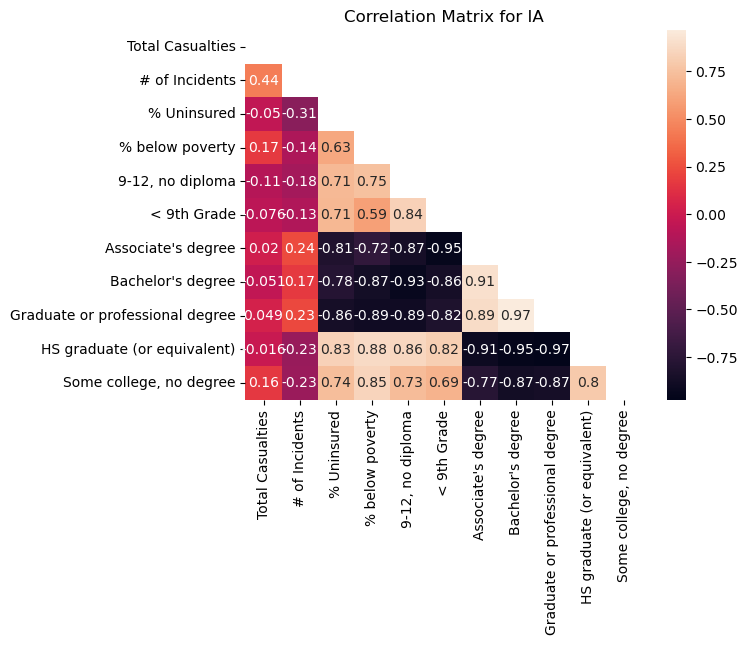

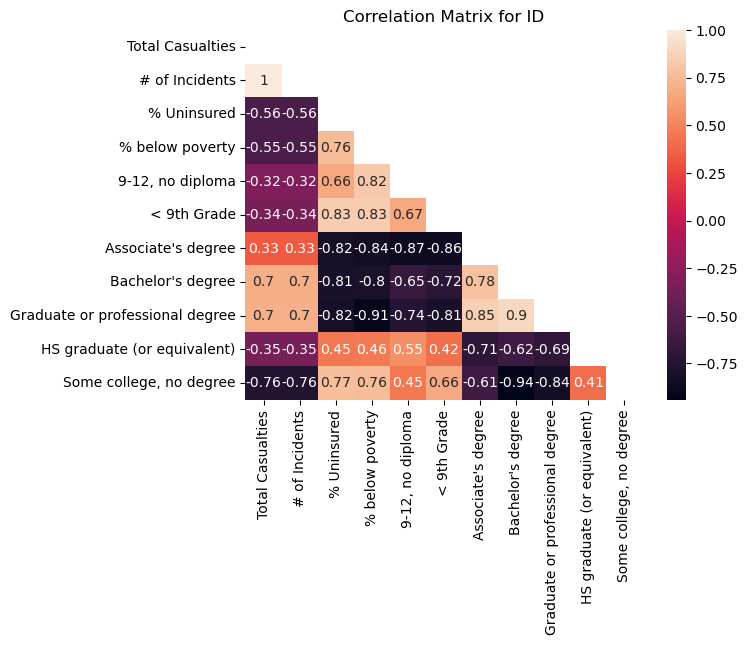

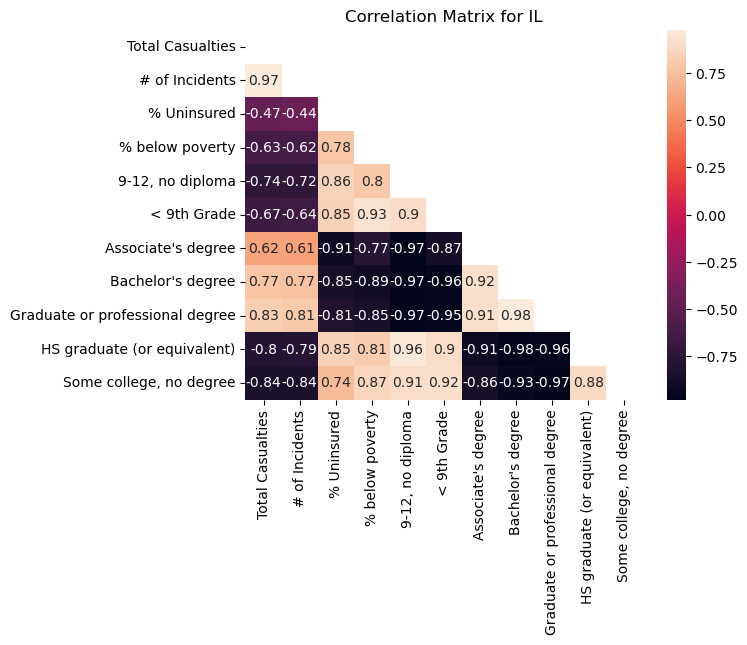

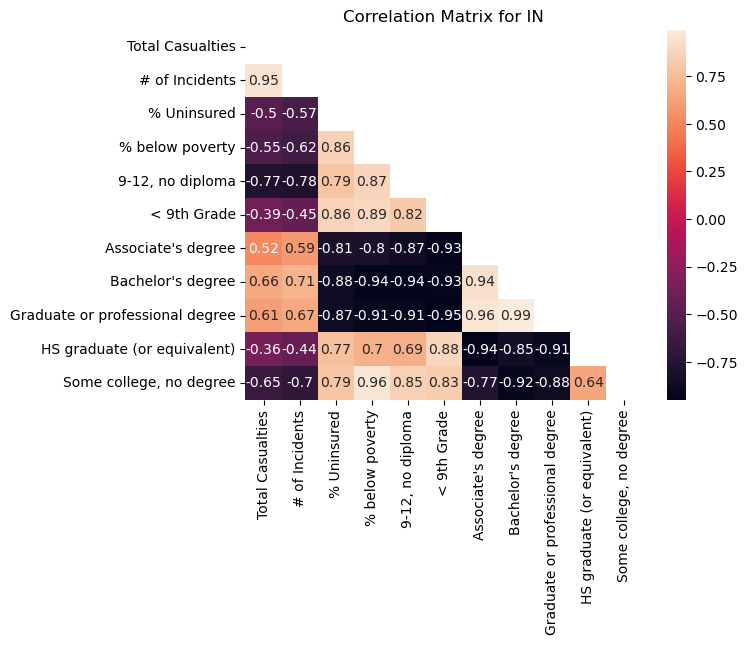

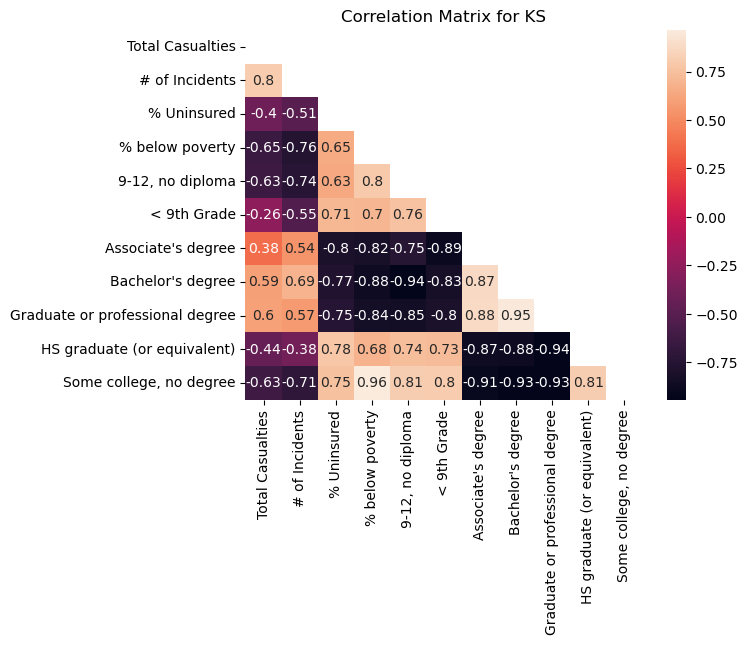

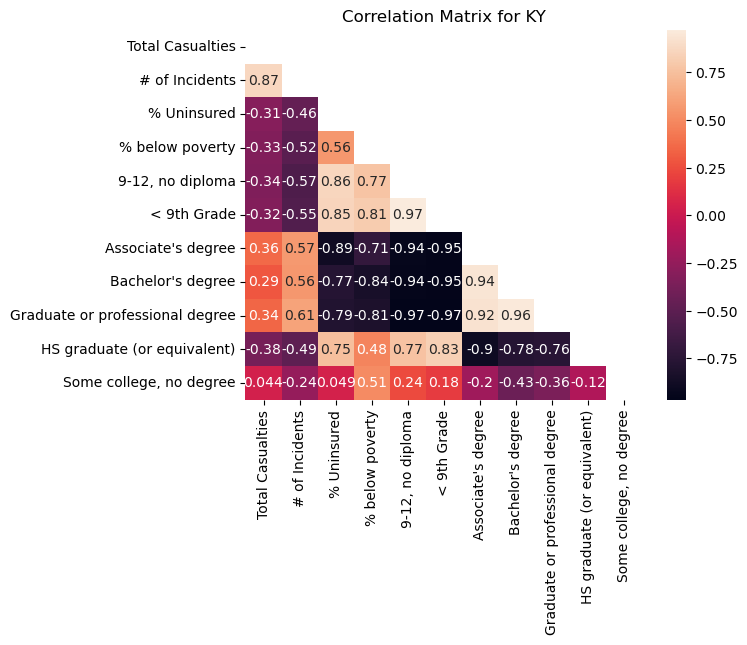

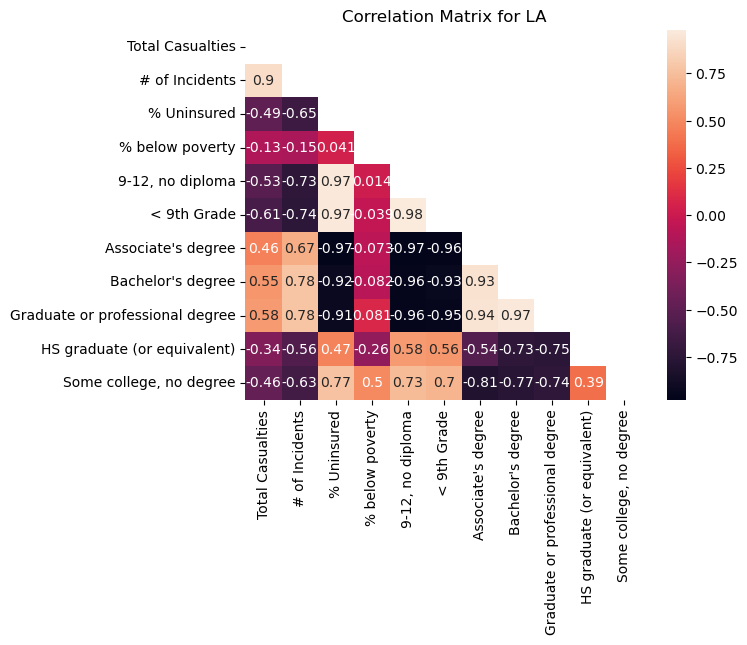

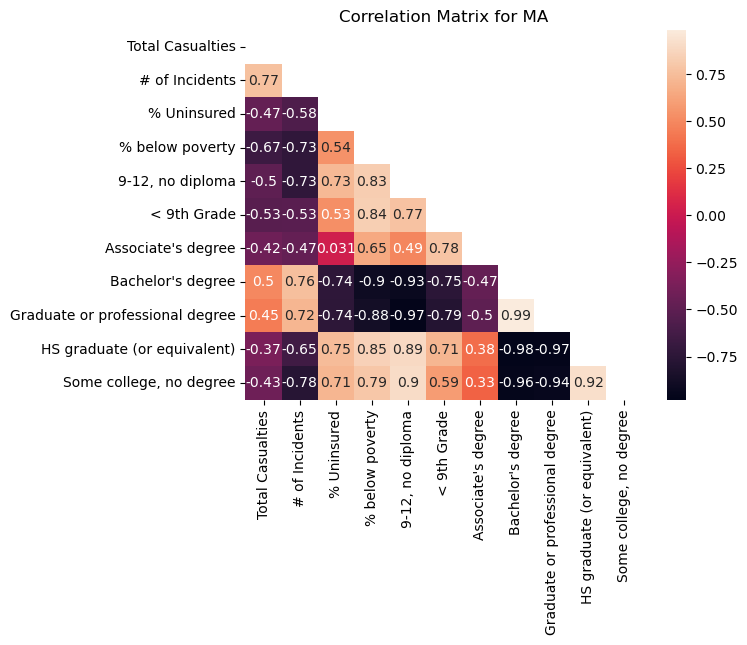

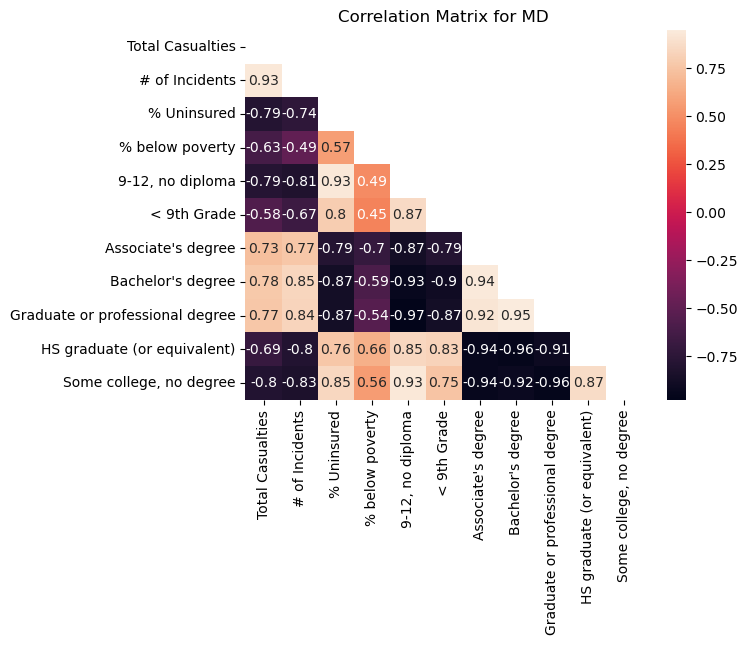

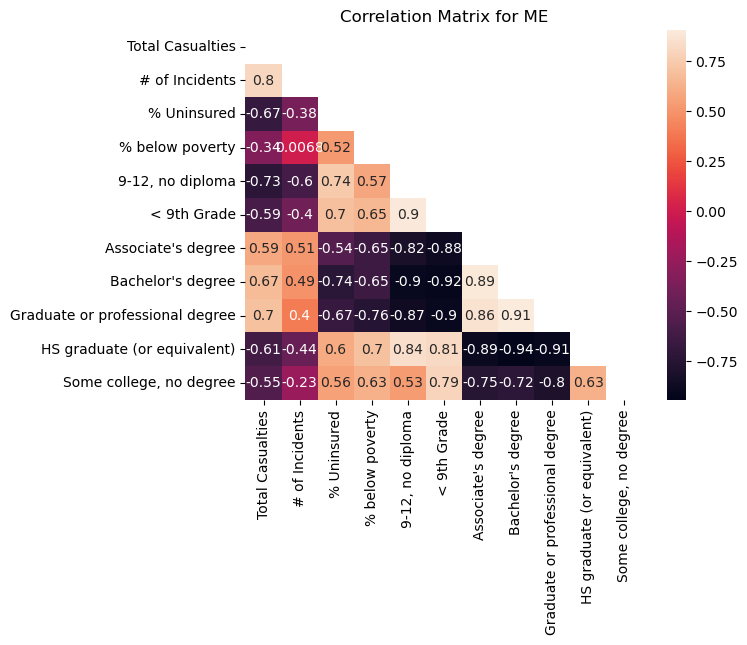

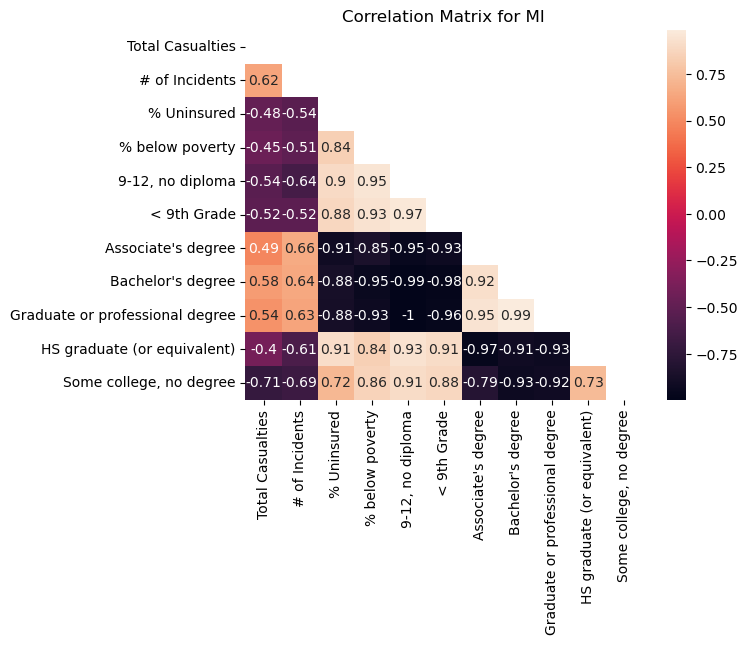

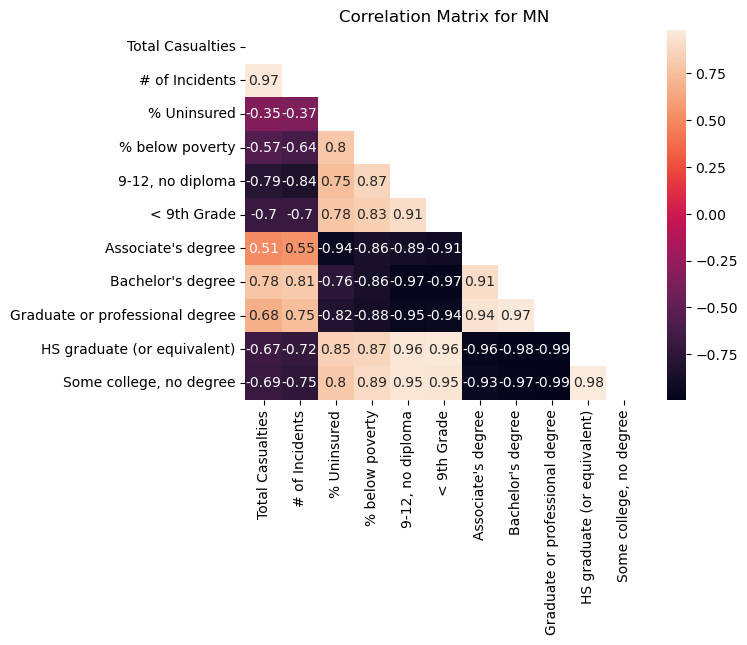

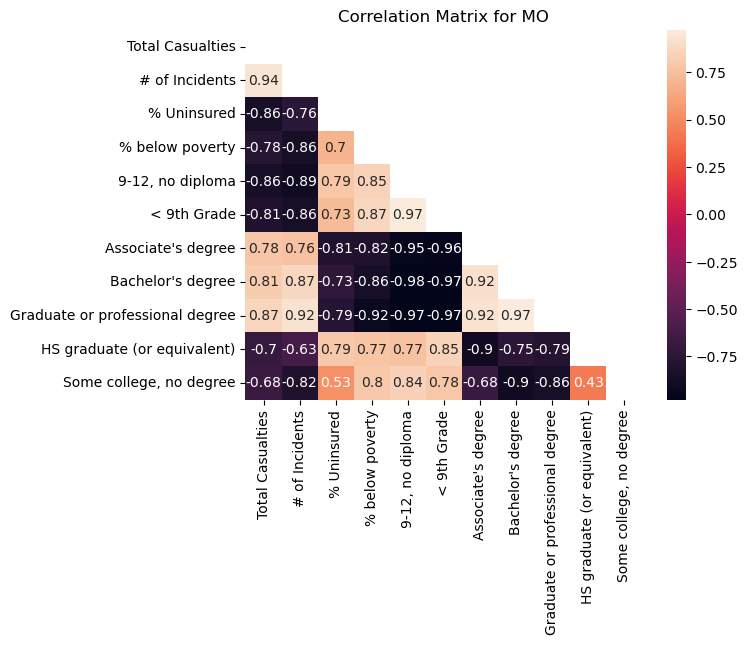

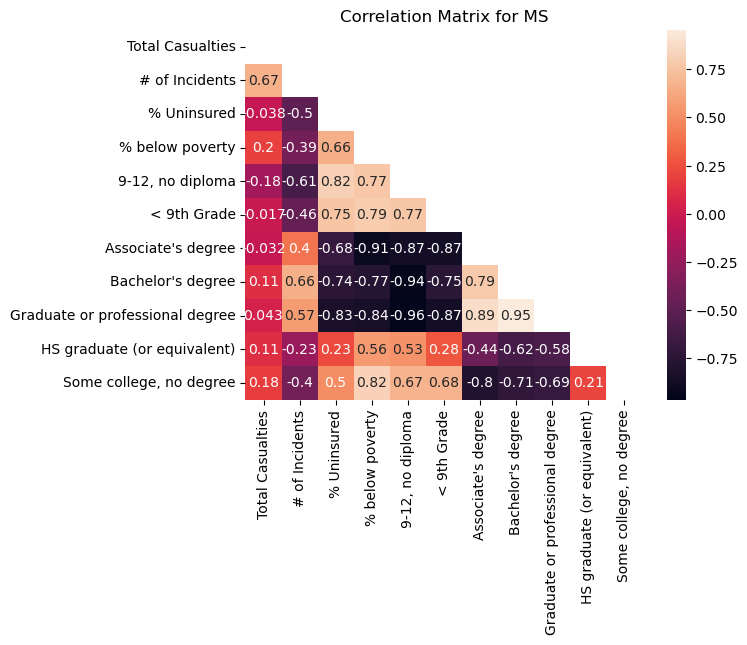

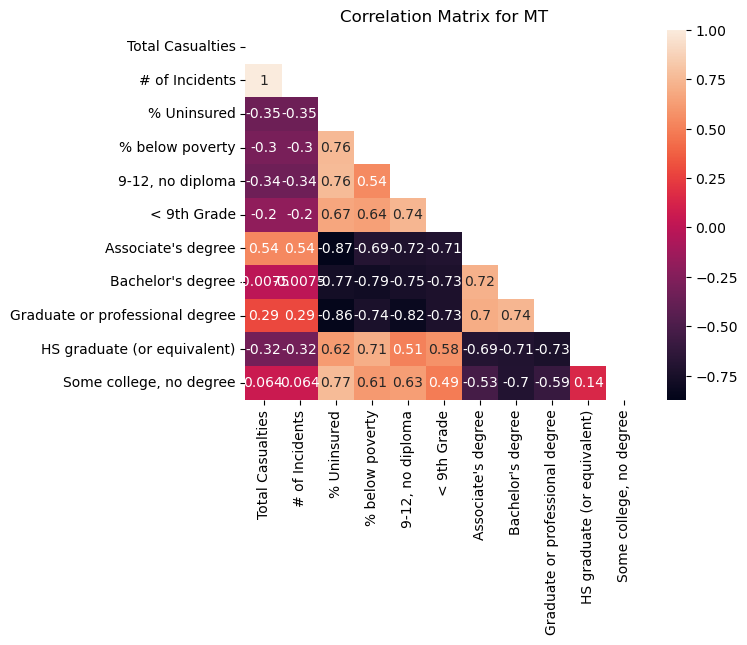

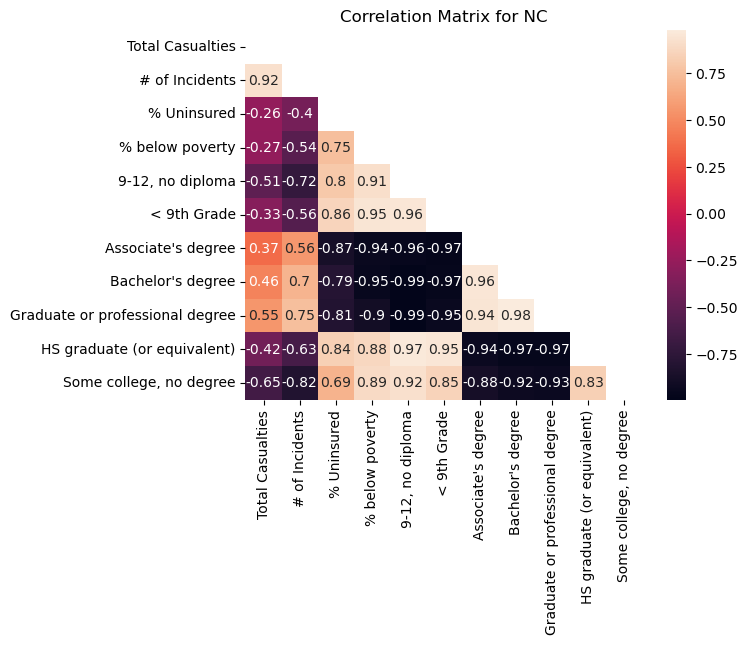

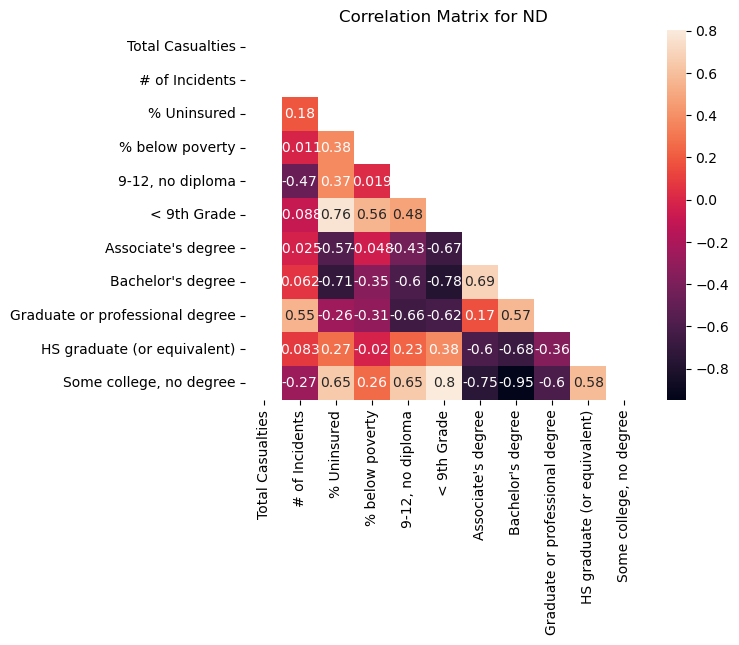

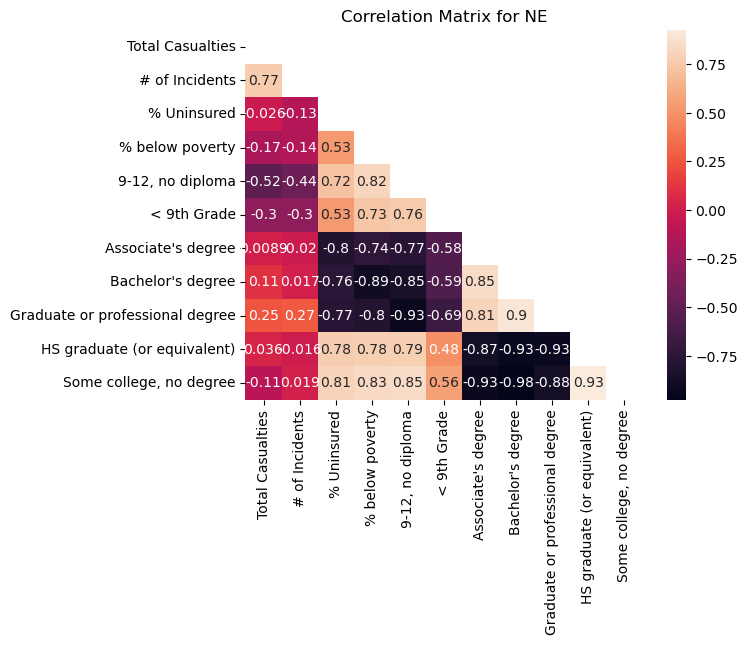

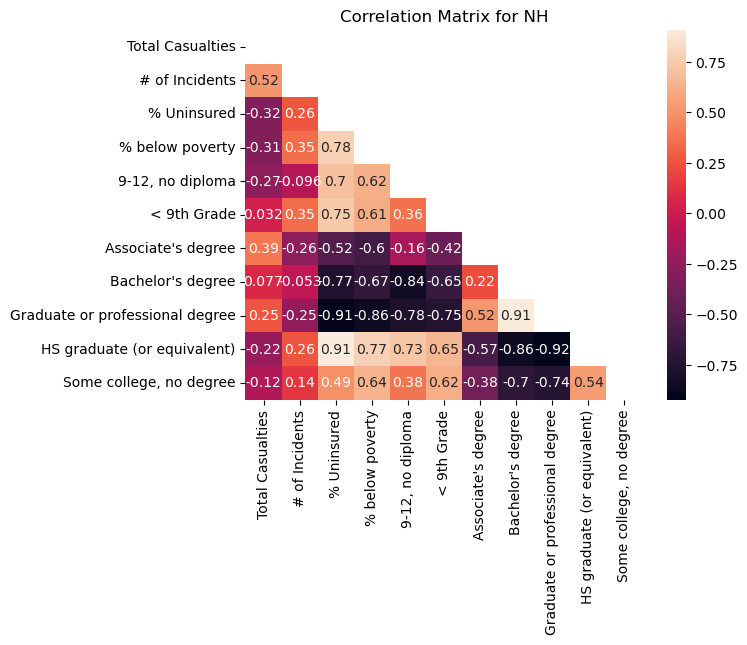

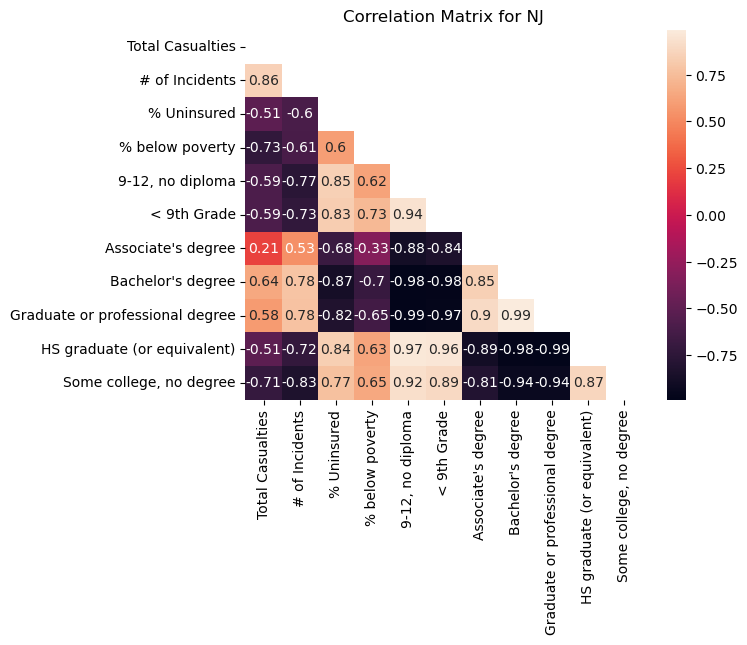

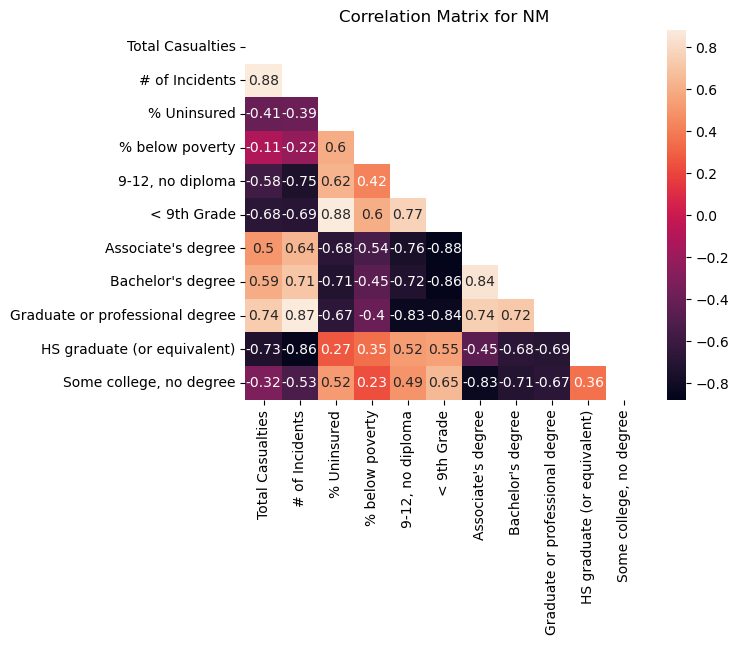

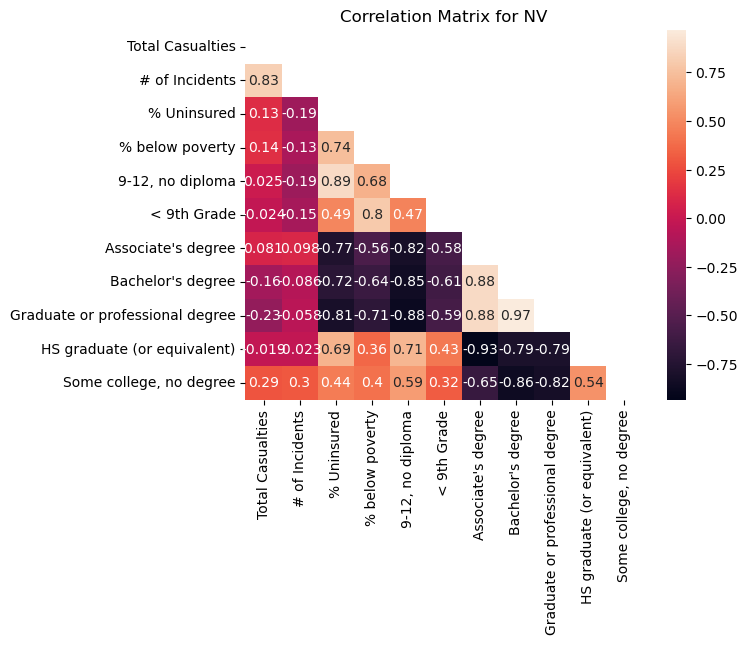

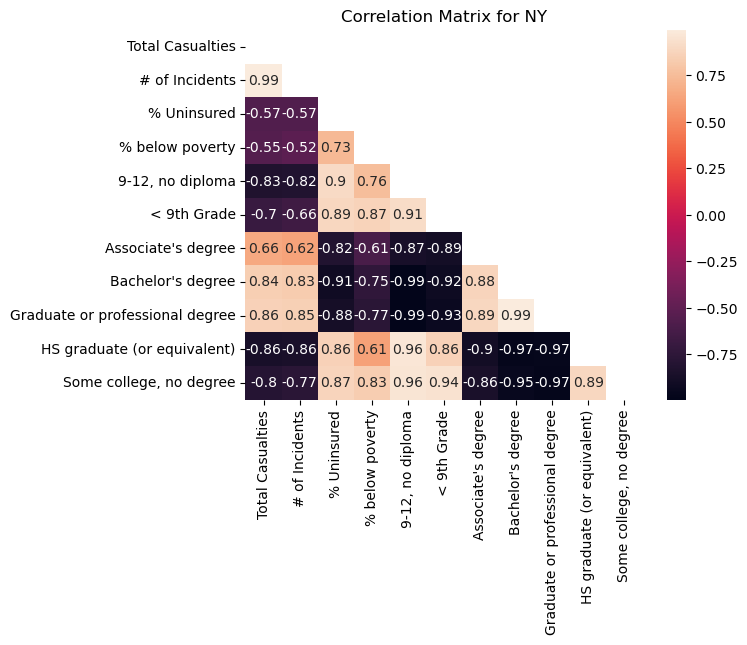

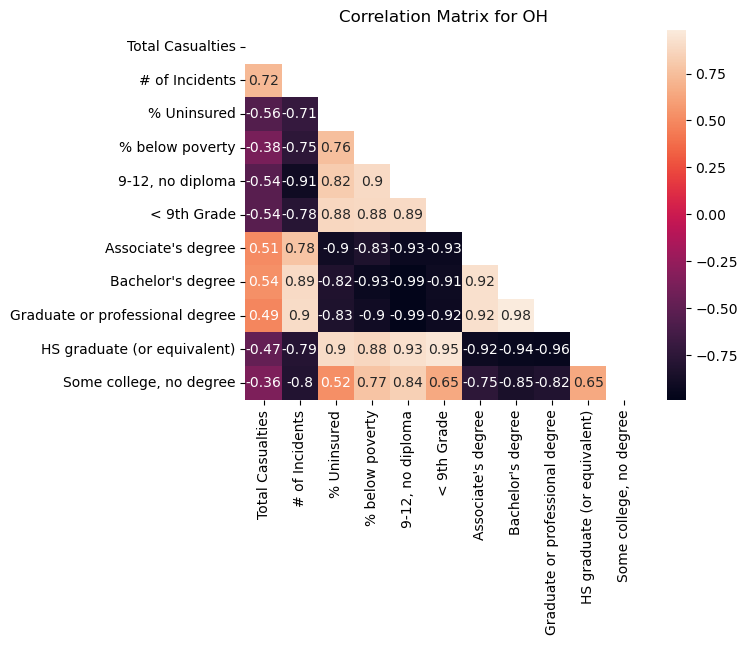

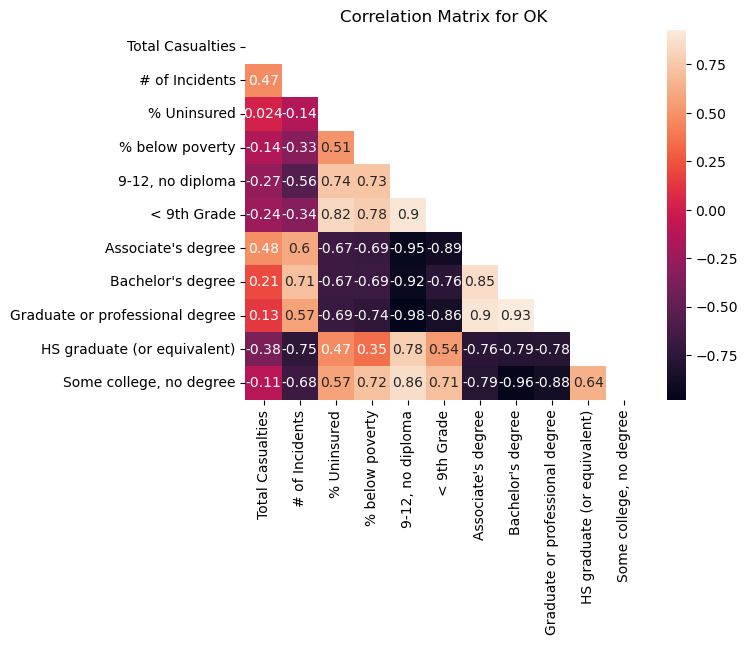

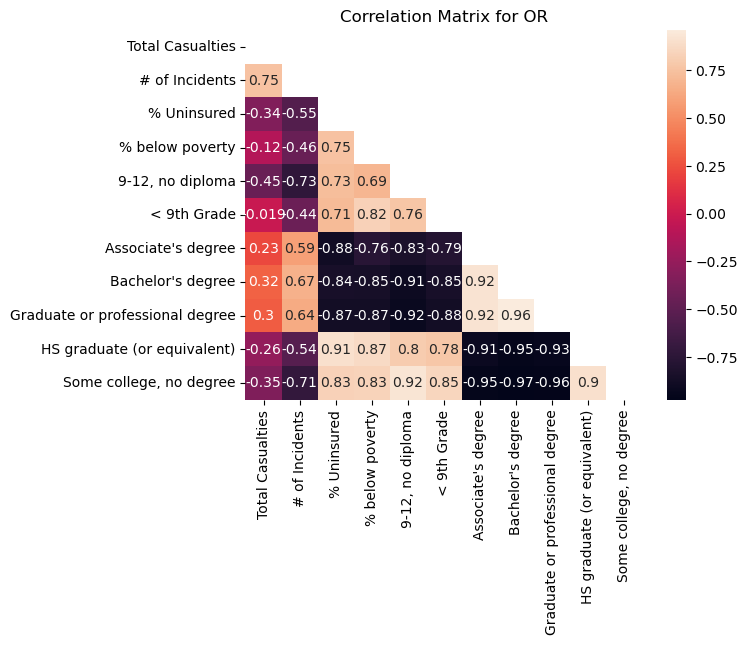

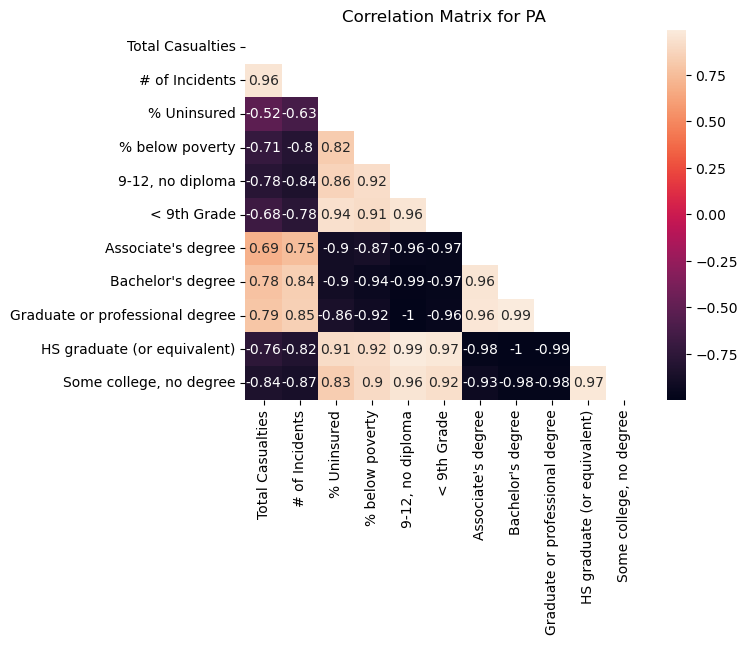

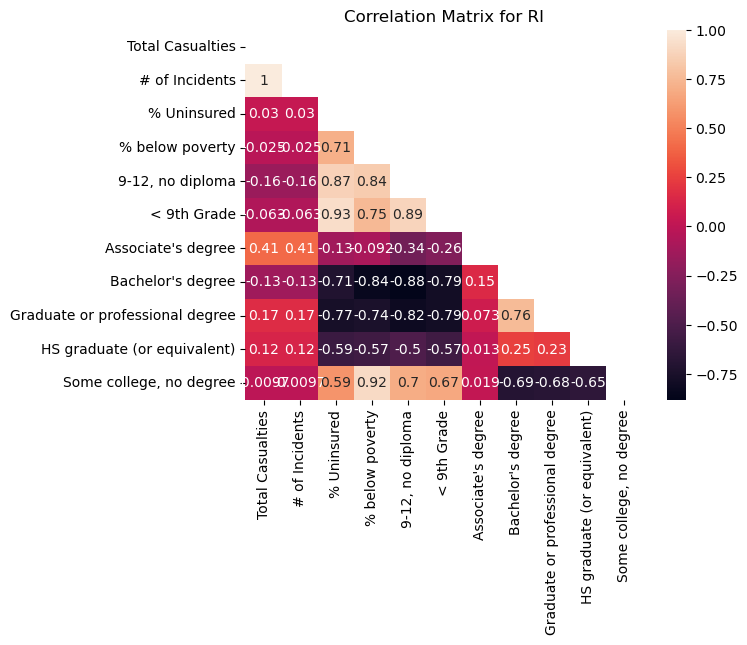

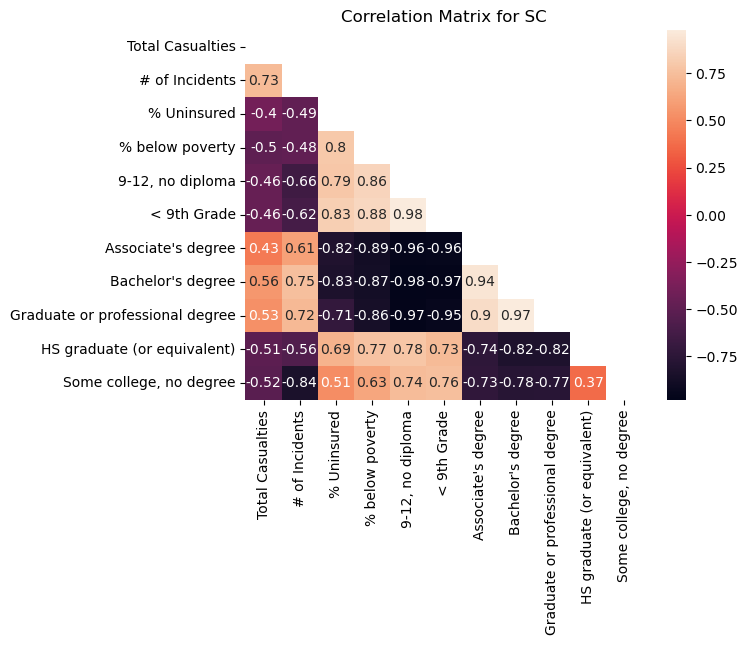

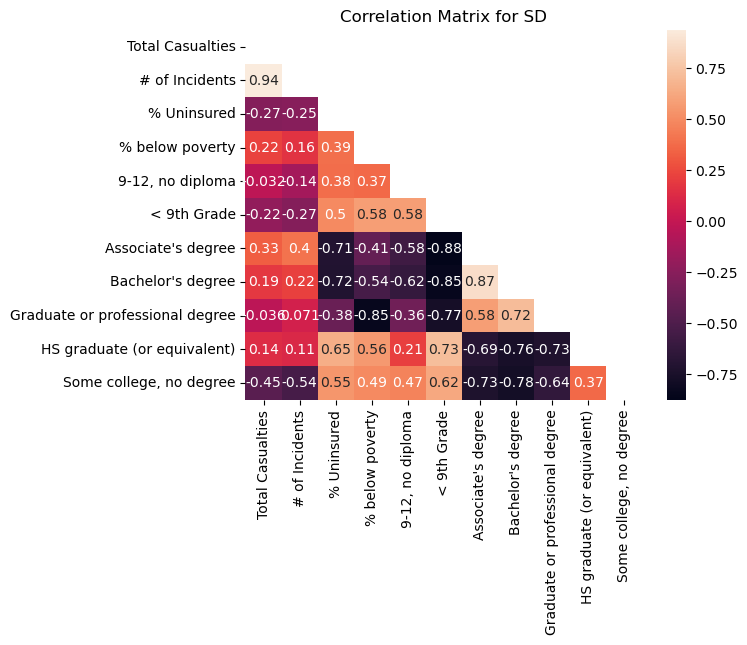

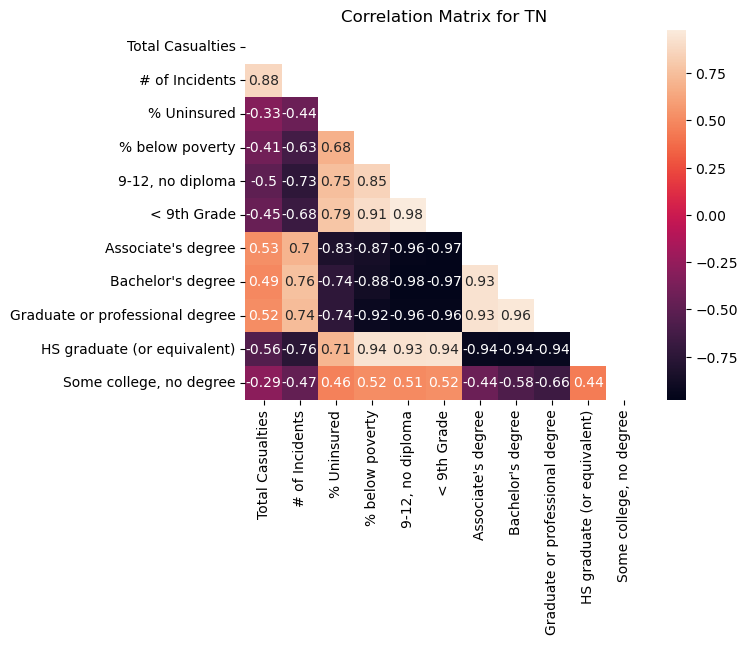

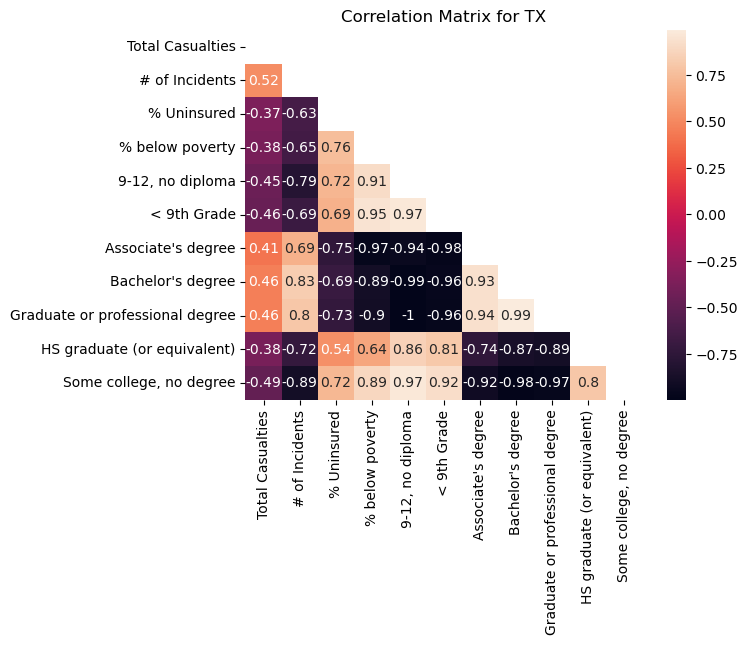

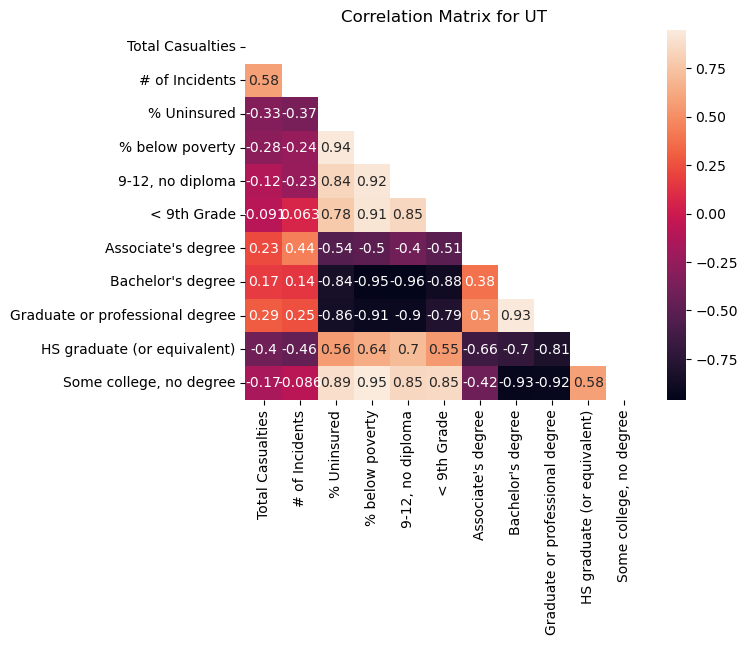

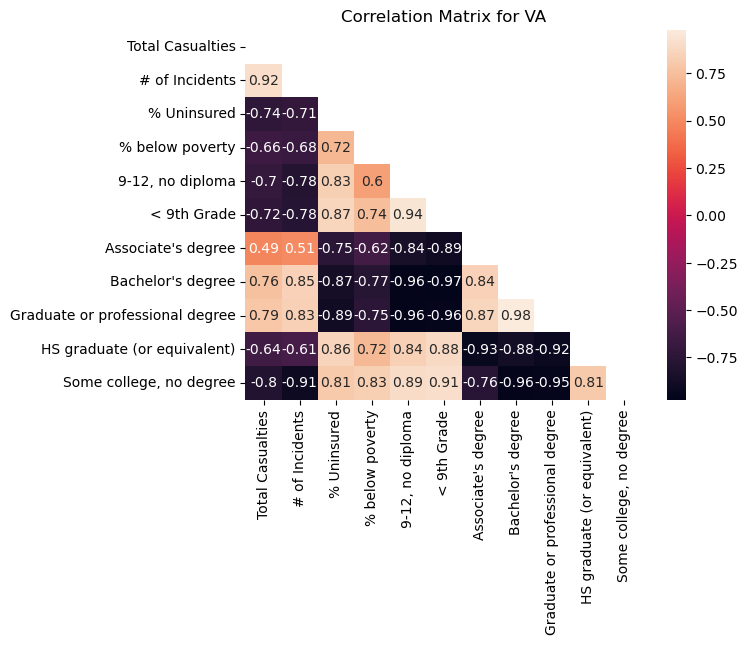

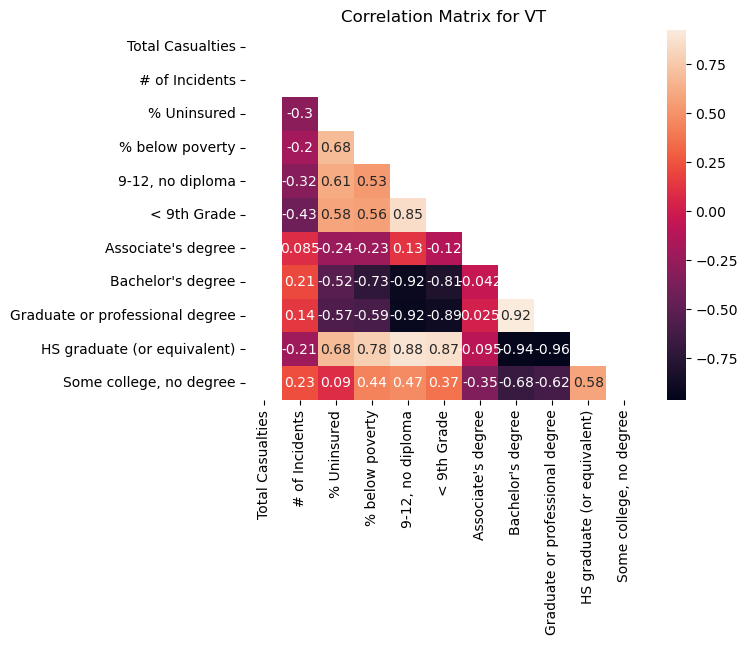

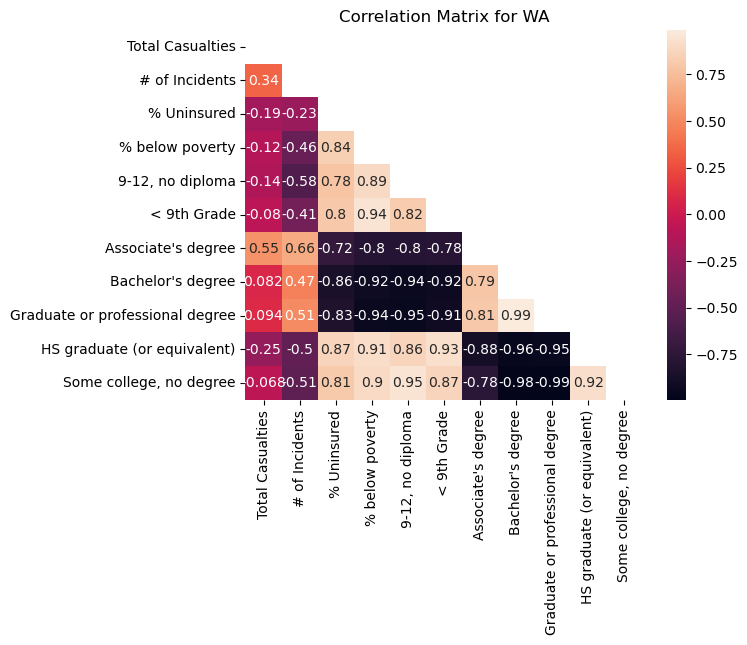

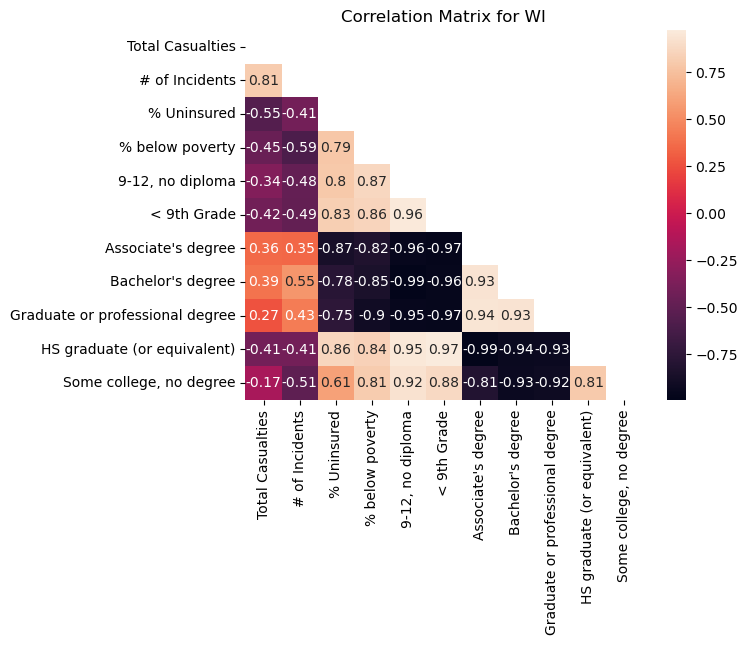

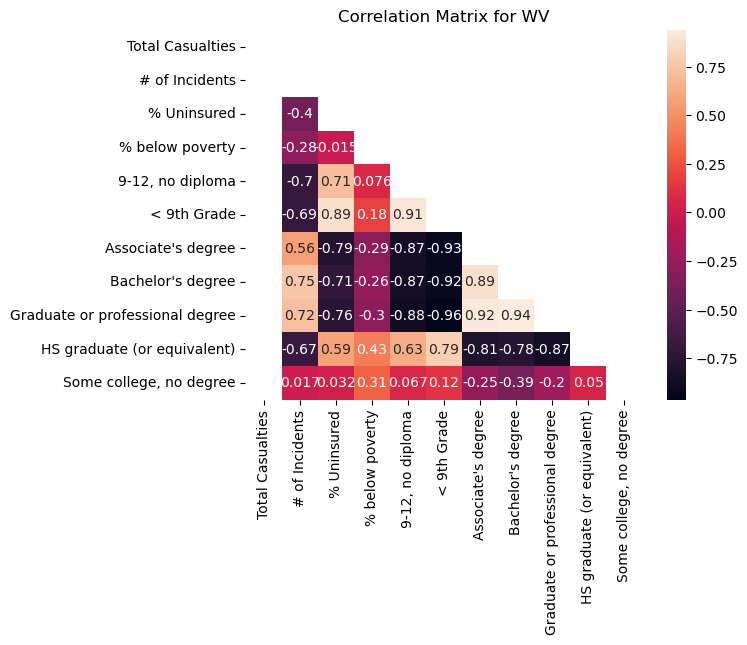

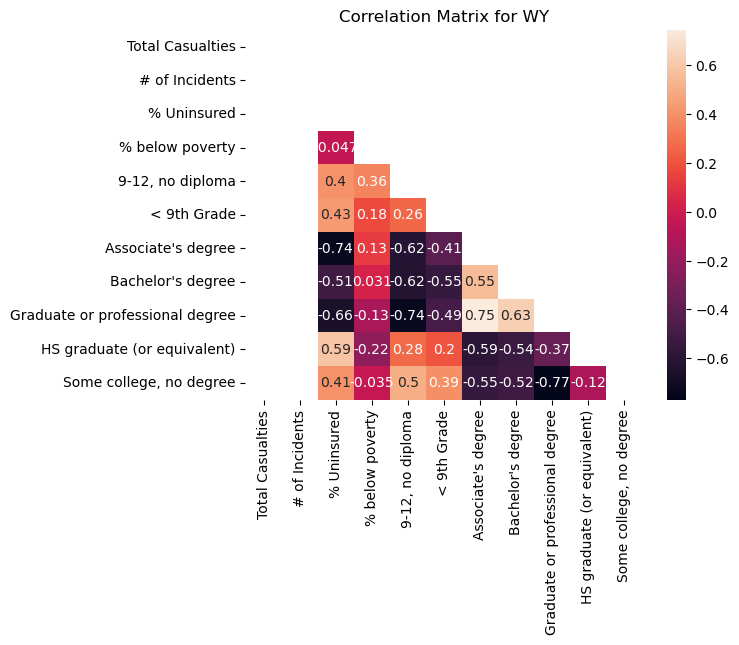

In [23]:
acsst_df = pd.read_parquet("../refined-data/refined-ACSST.parquet")

df = (
    ss_df
    .groupby([ss_df["Date"].dt.year, ss_df["State"]])["Number_Victims"]
    .agg(['sum','count'])
    .reset_index()
    .rename(columns={"Date": "Year", "count": "# of Incidents", "sum": "Total Casualties"})
)
df = df.query("2010 <= Year <= 2021 & Year != 2020")
acsst_subset = acsst_df[acsst_df.columns.difference(["Total Pop.", "Total Pop. ME"])]
acsst_subset = acsst_subset[[col for col in acsst_subset.columns if "ME" not in col]]
final = df.merge(acsst_subset, on=["Year", "State"])
for state, x in final.groupby("State"):
    corr = x.drop(["Year", "State"], axis=1).corr()
    matrix = np.triu(corr)
    sns.heatmap(corr, annot=True, mask=matrix)
    plt.title(f"Correlation Matrix for {state}")
    plt.show()